# DQN

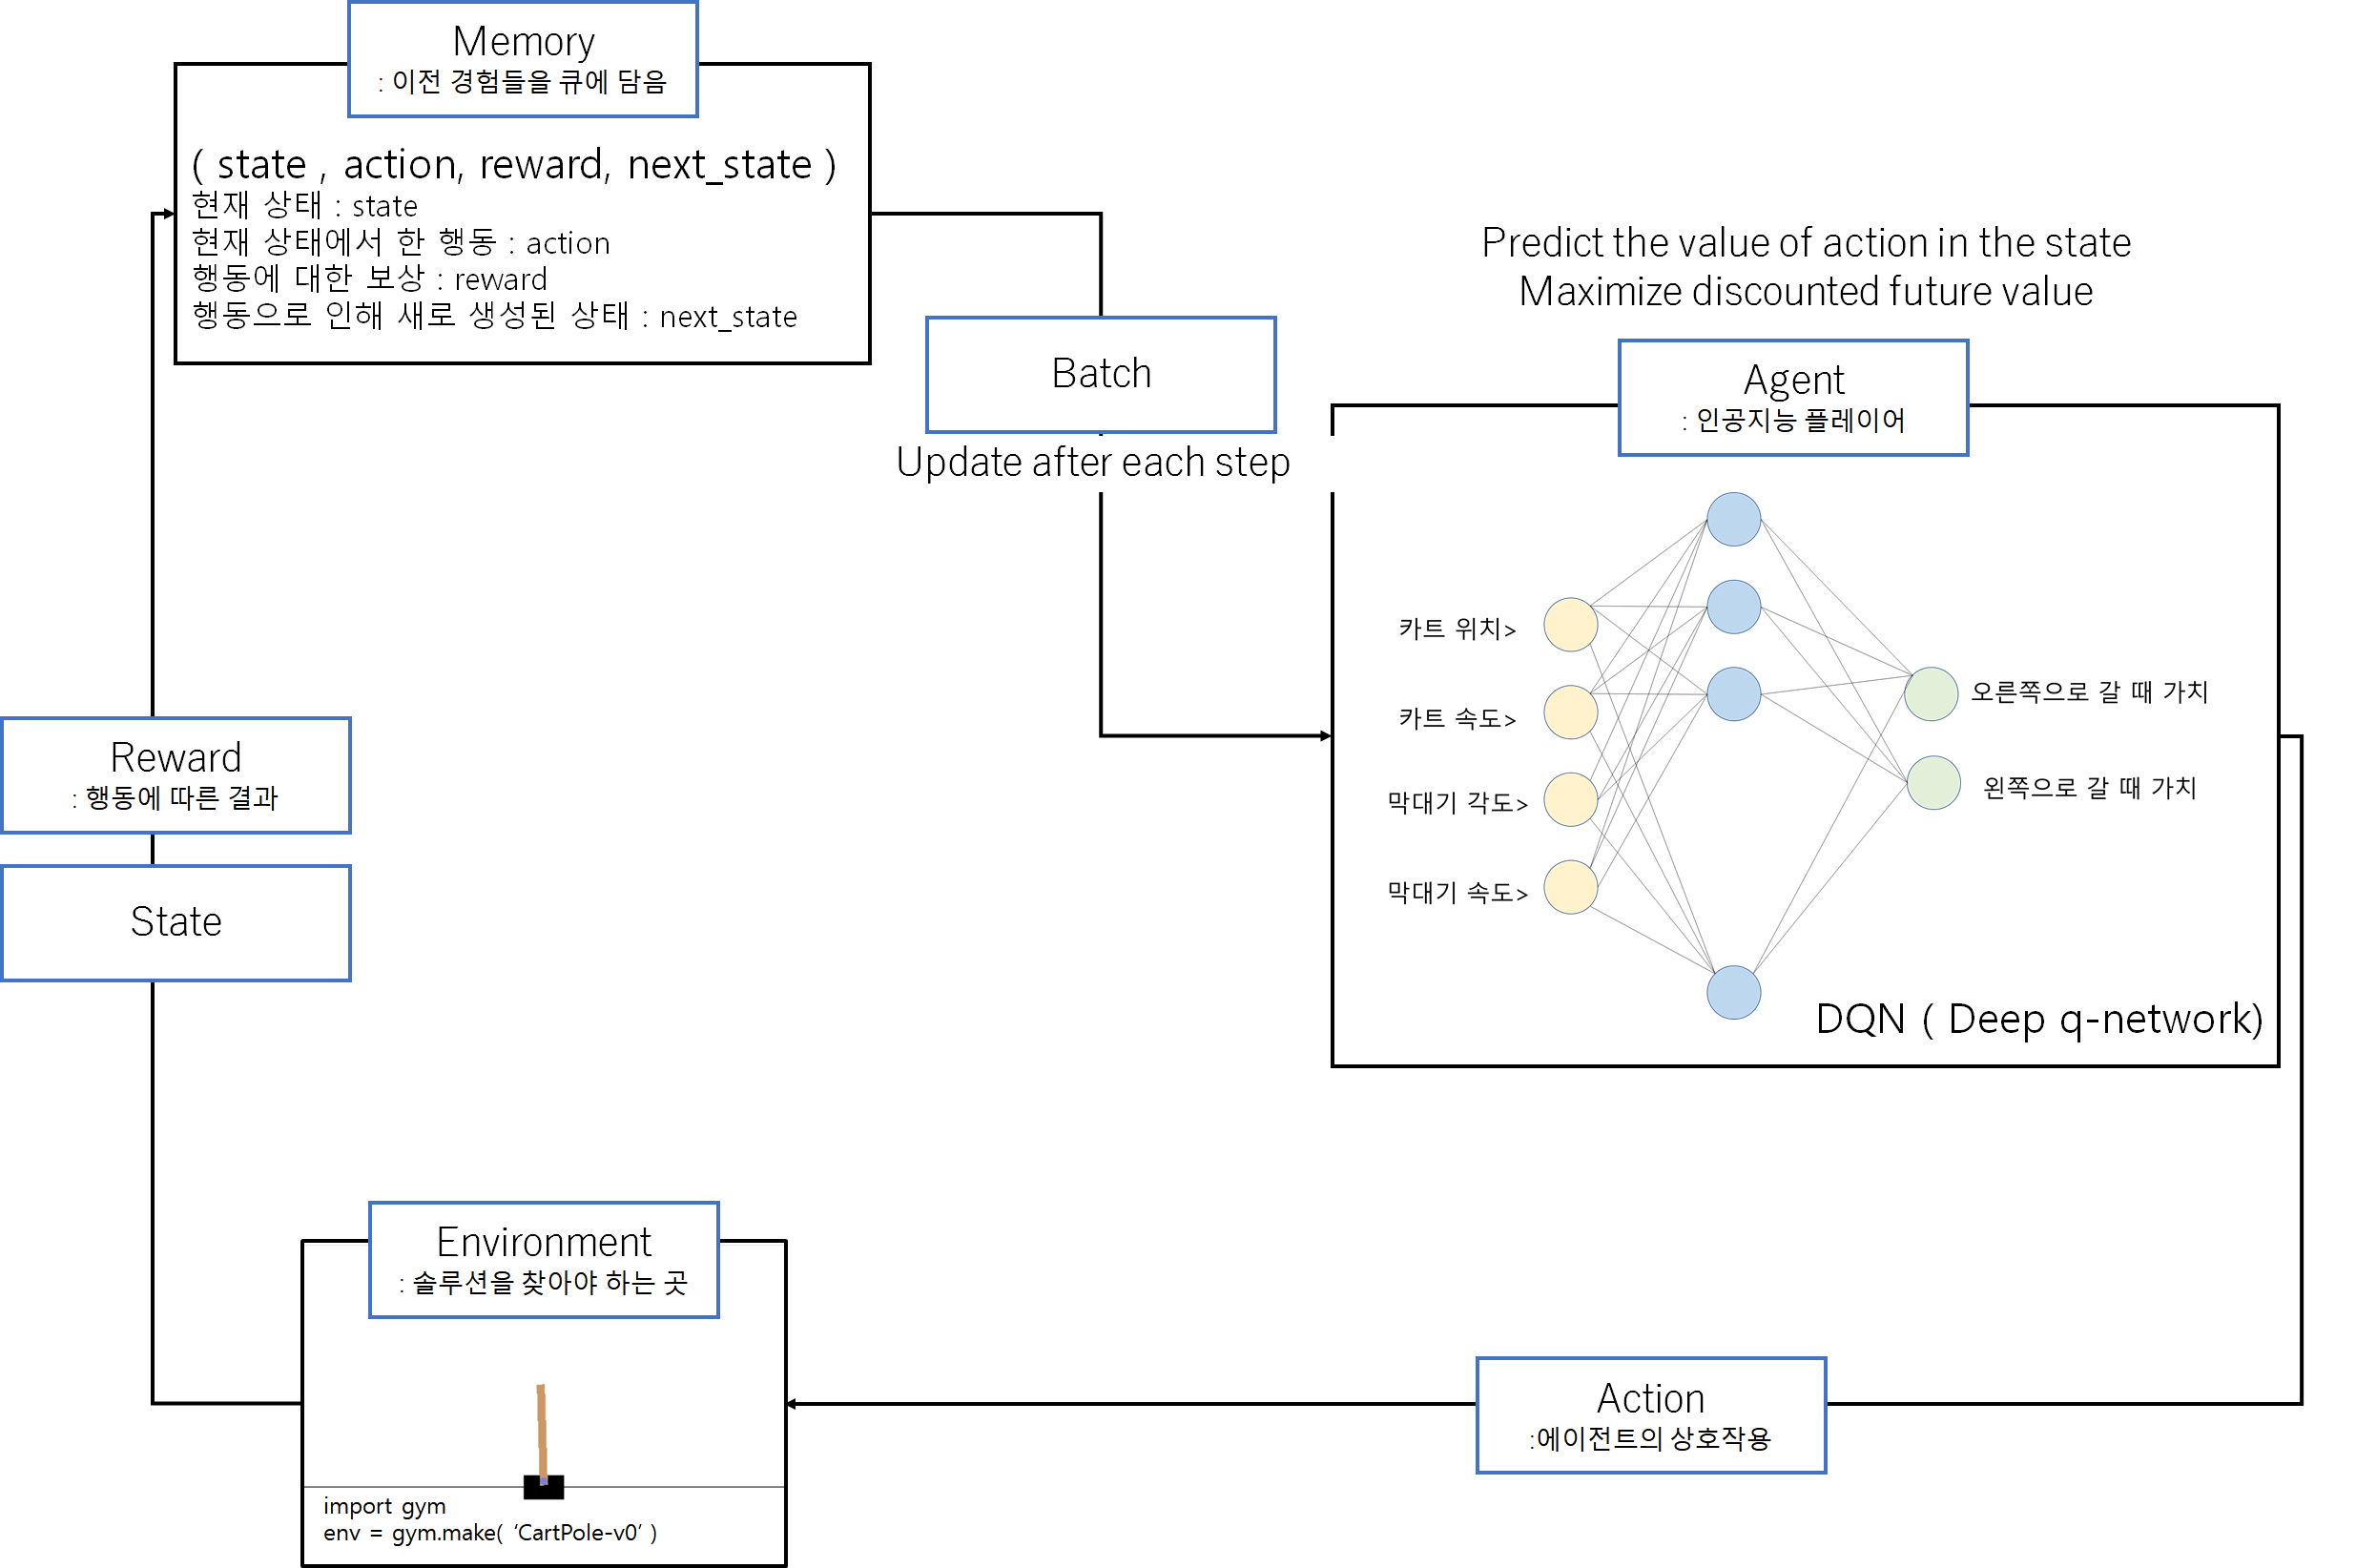

# 모듈 임포트

import gym -> 여러 게임 환경 제공 패키지
import random -> 무작위
import math -> 확률을 구하기 위한 수학 모듈
import deque -> double-ended queue


In [3]:

import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

# 하이퍼파라미터 

EPISODES -> 플레이할 게임 수 
엡실론 (EPS_START,EPS_END) ->  에이전트가 무작위로 행동할 확률 ( start 값에서 end 값으로 확률이 낮아진다.)
엡실론 감소율 ->  엡실론을 start 값에서 end 값으로 낮출 떄 낮아지는 값
GAMMA  -> 현재 보상을 미래 보상보다 얼마나 가치 있게 여기는지  ( 할인 계수 )

In [4]:
# 하이퍼파라미터
EPISODES = 50    # 애피소드 반복횟수
EPS_START = 0.9  # 학습 시작시 에이전트가 무작위로 행동할 확률
EPS_END = 0.05   # 학습 막바지에 에이전트가 무작위로 행동할 확률
EPS_DECAY = 200  # 학습 진행시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8      # 할인계수
LR = 0.001       # 학습률
BATCH_SIZE = 64  # 배치 크기

# DQN 에이전트 

## 1. 게임을 하기 위한 신경망

### def __init__(self)

에이전트 신경망은 ( 카트 위치, 카트 속도, 막대기 각도, 막대기 속도 ) 4가지 정보를 입력 받이 
왼쪽으로 갈 떄의 가치와 오른쪽으로 갈 떄의 가치를 2가지 정보를 출력한다. 

학습시 최적화 함수인 Adam 이용 

self.steps_done -> 학습을 반복할 떄마다 증가하는 함수 

self.memory = deque( maxlen = 10000 ) -> 큐로 구현한 메모리의 메모리가 가득차면 제일 오래된 요소 부터 자연스레 삭제 



## 2. 행동을 결정하기 위한 함수 

### def memorize(self,state, action, reward, next_state)
<DQN 이전 강화학습의 문제점>
1. 연속적 경험을 학습시 초반 패턴에 치중해서 학습
2. 새로운 경험이 전 경험에 겹쳐지면서 쉽게 잊혀진다.

-> 해결책 ' 가억하기'

기억한 경험들을 학습 시 무작위로 뽑아 경험 간의 상관관계를 줄인다. 

< 경험 memort 자료 구조 >

1. 현재 상태 (state)
2. 현재 상태에서 한 행동 (action)
3. 행동에 대한 보상 (reward)
4. 행동으로 인해 새로 생성된 상태 (next_state)

### act(self, state)

무작위로 숫자를 골라 엡실론 값보다 높으면 신경망이 이 방향이 옳다고 학습하고, 아닌 경우 무작위로 행동
학습 초반에는 학습이 덜되었기 때문에 에이전트가 하는 행동에 의미를 부여할 수 없다.
그렇기 때무에 초반에는 엡실론 값을 높게 주어서 다양한 경험을 하도록 하고,
점점 그 값을 낮춰가면서 신경망이 결정하는 비율을 높인다. 
-> epsilon-greed 알고리즘



## 3. 행동의 가치를 학습하는 함수 

### def act(self, state) 

#### 학습을 위한 경험 샘플 준비 
experience replay : DQN 에이전트가 기억하고 다시 상기하는 과정을 수행 

if len(self.memory) < BATCH_SIZE:
            return 
self.memory 에 저장된 경험들의 수가 아직 배치 크기보다 커질 때까지 return 으로 학습을 거르고,

batch = random.sample(self.memory, BATCH_SIZE)
만약 경험이 충분히 쌓이면 self.memory 큐에서 무작위로 배치 크기 만큼의
'경험'들을 무작위로 가져온다.
-> 각 경험들을 무작위로 가져와 샘플의 상관성을 줄인다.
states, actions, rewards, next_states = zip (* batch)
(states, actions, rewards, next_states) 가 한세트인 배열 각각 4개의 배열로 나눈다 .
 
states = torch.cat(states) -> 상태 
actions = torch.cat(actions) -> 행동 
rewards = torch.cat(rewarsds) -> 행동에 따른 보상
next_states = torch.cat(next_states) -> 다음 상태
torch.cat() 함수를 이용해 리스트 형태를 하나의 텐서로 만든다. 

#### 에이전트 신경망을 학습
에이전트가 점진적으로 발전된 행동을 하려면 갖고 있는 신경망이 주어진 상태(states)에서 
각 행동의 가치(Q)를 더 잘 예측하도록 학습되어야 한다.
-> 현재 상태에서 에이전트가 생각하는 행동의 가치를 추출해야 한다.
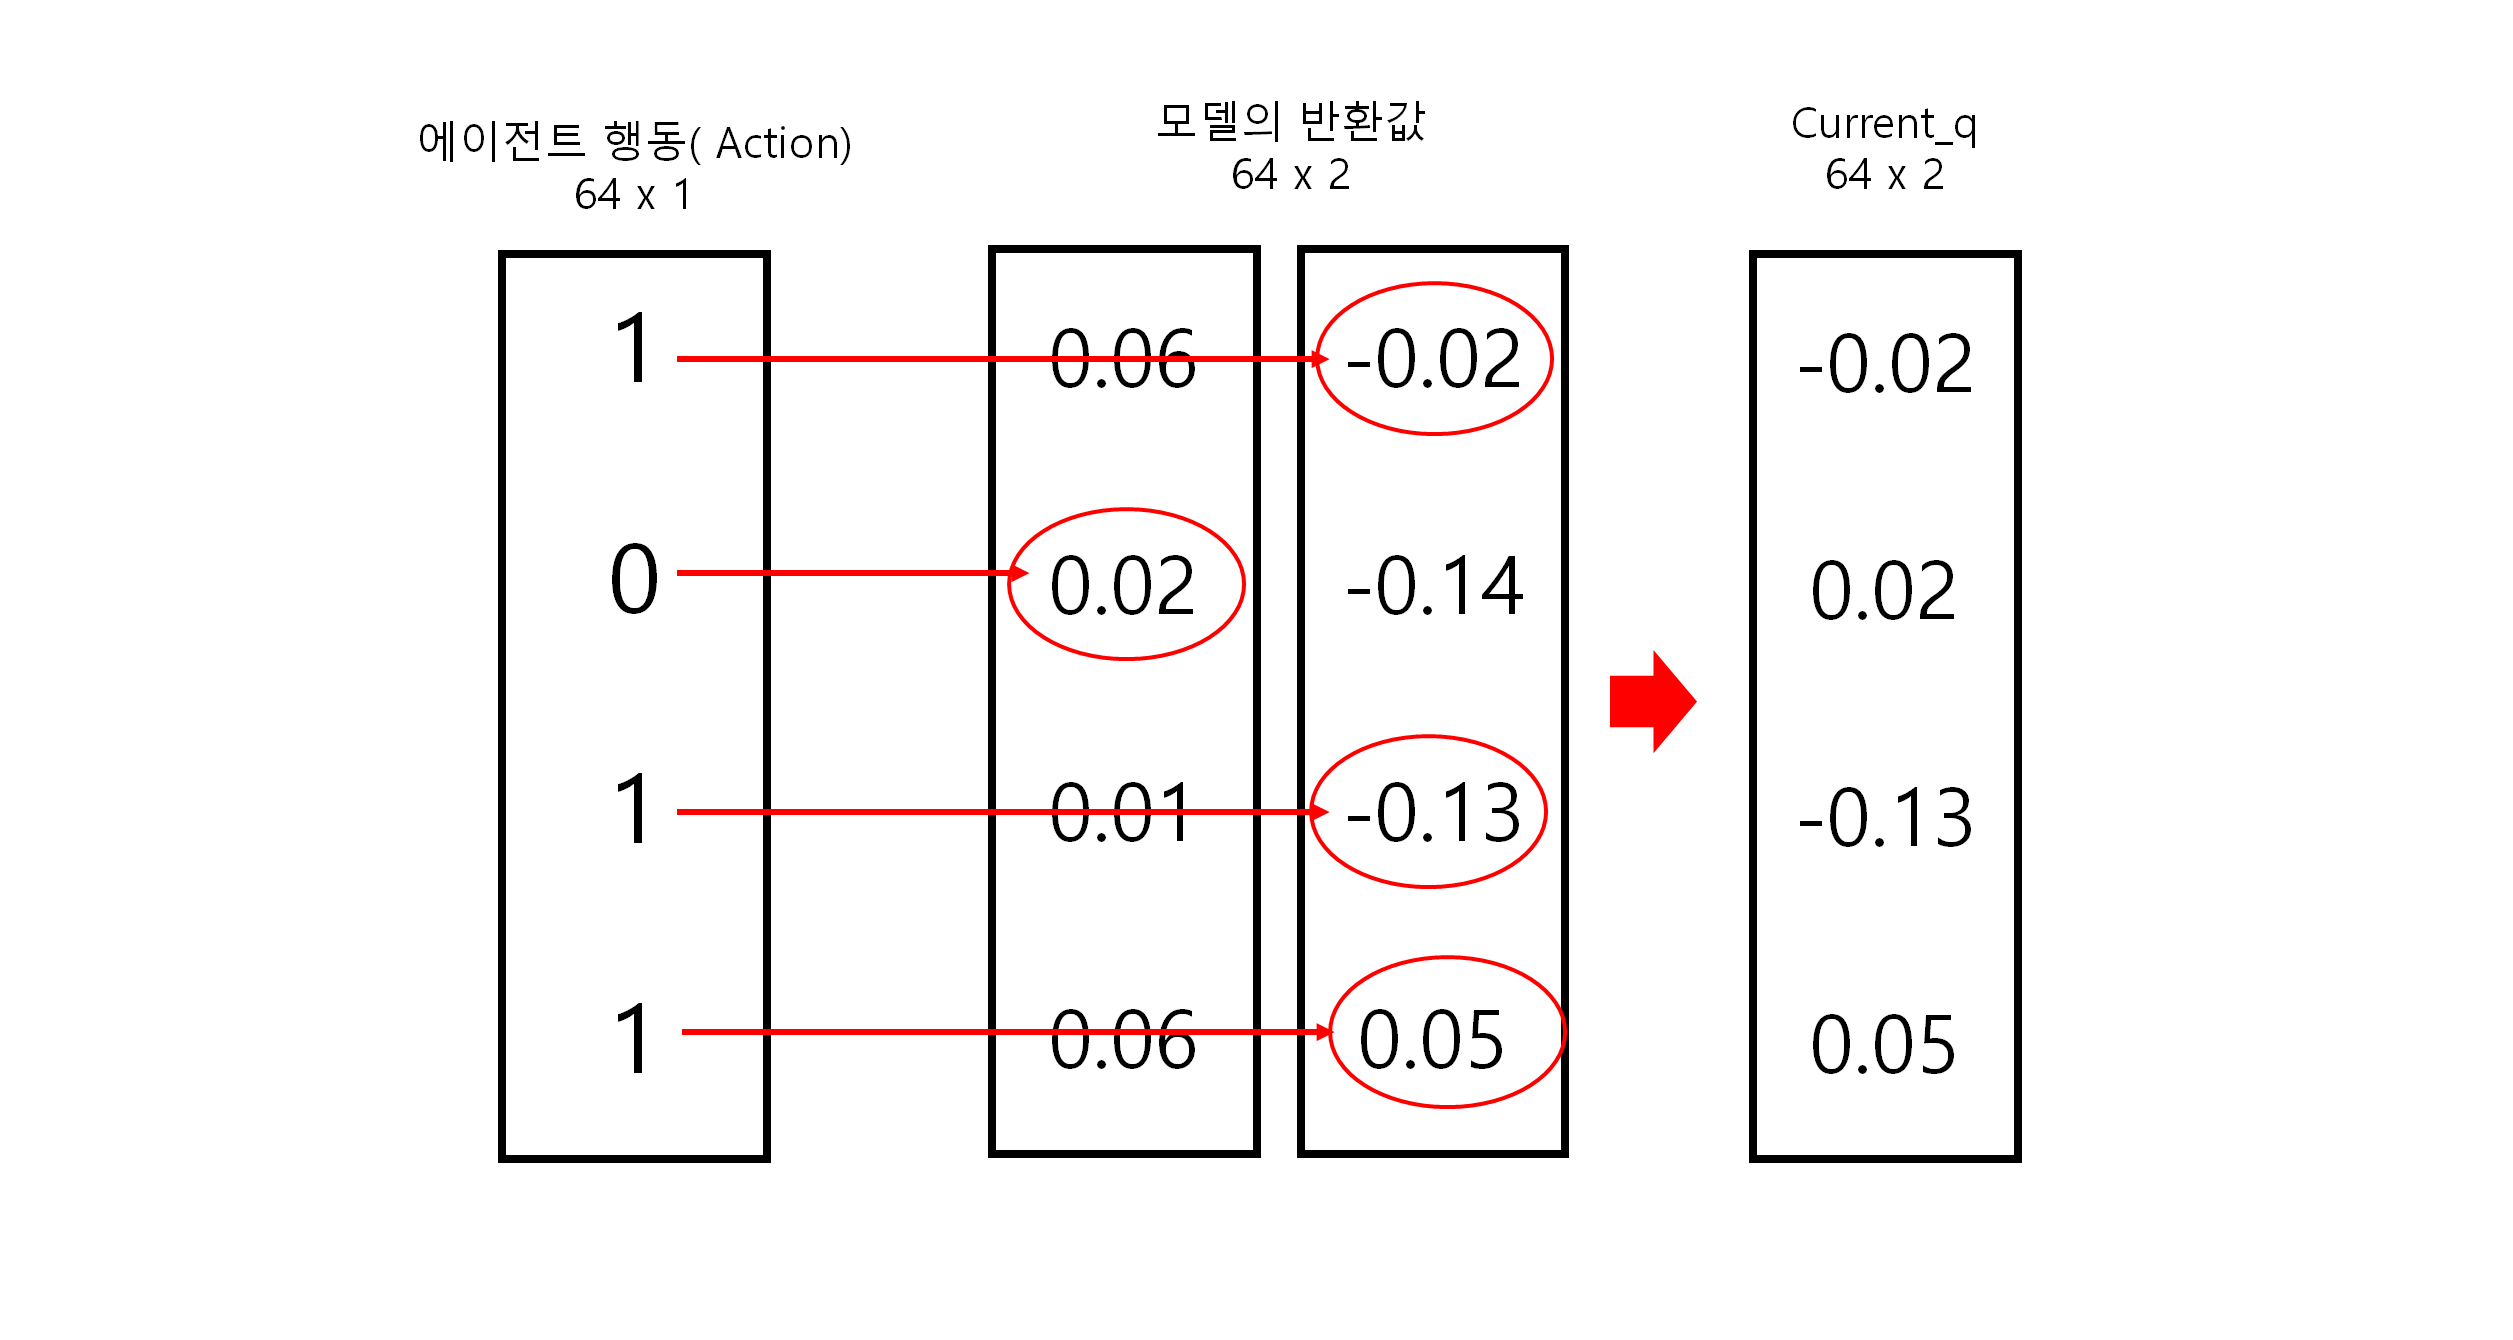
current_q = self.model(state).gather(1,actions)
현재 상태를 신경망에 통과시켜서 왼쪽으로 가는 행동과 오른쪽으로 가는 행동의 가치 계산
gather() 함수로 '에이전트가 현 상태'에서 했던 행동의 가치들을 current_q에 담는다.
gather() 함수는 첫 번째 인수로 받은 차원(1) 에서 
두 번째 인수로 인수로 받은 텐서(actions)가 가리키는 값들을 추출한다.

#### 할인된 미래 가치 

max_next_q = self.model(next_states).detach().max(1)[0]


expected_q = rewards + (GAMMA * max_next_q)
할인된 미래 가치 = 행동해 받았던 보상 (rewards) +  행동들의 미래 가치 (max_next_q )    

loss = F.mse_loss(current_q.squeeze(), expectd_q) 
오차를 계산 
self.optimizer.zero_grad()
loss.backward()
self.optimizer.step()
역전파 


In [5]:
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0
        self.memory = deque(maxlen=10000)

    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))
    
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q)
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# 학습 준비하기 

env = gym.make('CartPole-v0')
env 변수는 이제 게임 환경이 되어 여기에 에이전트 행동을 입력하면 행동에 따른 다음 상태와 게임 종료 여부를 출력

agent = DQNAgent()
 DQNAgent를 소환해서 agent로 인스턴스화 
 
score_history =[]
학습 진행을 score_history 리스트에 점수를 저장

In [6]:
# 학습 준비하기
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

# 학습 시작하기

for e in range(1, EPISODES +1): -> 50번 동안 게임을 한다.
state = env.reset() -> 게임 초기화 


while True:  -> 게임이 끝날 때까지 에이전트 행동을 멈추지 않음 
env.render() -> 게임 화면 띄우기 
state = torch.FloatTensor([state]) -> 현재 게임 상태 state를 텐서로 만든다.
action = agent.act(state) -> 엡실론 그리디 알고리즘에 따른 action을 출력 
next_state, reward, done, _ = env.step(action.item()) 
-> action.item() 로 에이전트가 한 행동의 번호를 추출해 step() 에 입력하면 
행동에 따른 다음 상태, 보상, 종료 여부를 출력
        
if done:
    reward = -1
-> 게임이 끝났으면 -1 보상 즉, 처벌을 준다.

agent.memorize(state, action, reward, next_state)
-> 경험을 기억한다.
agent.learn()
-> 결과를 배운다.

state = next_state
steps += 1

if done:
    print('에피소드:{0} 점수: {1}'.format(e,steps))
    score_history.append(steps)
    break
    
게임이 끝나면 done이 True가 되며 score_history ㄹ스트에 점수를 담고,break

In [7]:
#학습 시작
for e in range(1, EPISODES +1):
    state = env.reset()
    steps = 0
    
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action.item())
        
    # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1
    
        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print('에피소드:{0} 점수: {1}'.format(e,steps))
            score_history.append(steps)
            break

에피소드:1 점수: 22
에피소드:2 점수: 10
에피소드:3 점수: 32
에피소드:4 점수: 33
에피소드:5 점수: 16
에피소드:6 점수: 21
에피소드:7 점수: 11
에피소드:8 점수: 19
에피소드:9 점수: 9
에피소드:10 점수: 10
에피소드:11 점수: 17
에피소드:12 점수: 10
에피소드:13 점수: 10
에피소드:14 점수: 11
에피소드:15 점수: 9
에피소드:16 점수: 9
에피소드:17 점수: 9
에피소드:18 점수: 11
에피소드:19 점수: 9
에피소드:20 점수: 9
에피소드:21 점수: 10
에피소드:22 점수: 9
에피소드:23 점수: 13
에피소드:24 점수: 16
에피소드:25 점수: 14
에피소드:26 점수: 35
에피소드:27 점수: 54
에피소드:28 점수: 35
에피소드:29 점수: 63
에피소드:30 점수: 30
에피소드:31 점수: 49
에피소드:32 점수: 73
에피소드:33 점수: 85
에피소드:34 점수: 60
에피소드:35 점수: 133
에피소드:36 점수: 75
에피소드:37 점수: 37
에피소드:38 점수: 106
에피소드:39 점수: 121
에피소드:40 점수: 189
에피소드:41 점수: 124
에피소드:42 점수: 200
에피소드:43 점수: 106
에피소드:44 점수: 139
에피소드:45 점수: 192
에피소드:46 점수: 106
에피소드:47 점수: 170
에피소드:48 점수: 145
에피소드:49 점수: 116
에피소드:50 점수: 157


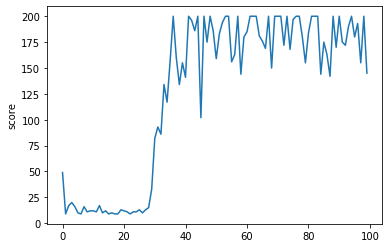

In [9]:
plt.plot(score_history)
plt.ylabel('score')
plt.show()